<a href="https://colab.research.google.com/github/N2000-hack/Machine-Learning-LAB/blob/main/SAM_Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING LIBRARIES**

In [10]:
# Installing and updating essential libraries and tools
#XGBoost stands for eXtreme Gradient Boosting. XGBoost is a scalable and accurate implementation of gradient boosting machines
!pip install xgboost -U 
#librosa is a python package for music and audio analysis.
!pip install librosa -U
#Hyperopt is a powerful python library for hyperparameter optimization,  that allows you to get the best parameters for a given model.
#hyperparameter - It is a machine learning parameter whose value is chosen before a learning algorithm is trained. 
!pip install hyperopt

In [11]:
#Warning messages are typically issued in situations where it is useful to alert the user of some condition in a program, 
#where that condition (normally) doesn't warrant raising an exception and terminating the program.
import warnings
warnings.simplefilter("ignore", UserWarning)
#os provides functions for creating and removing a directory
import os
#tqdm allows you to output a smart progress bar by wrapping around any iterable.
from tqdm import tqdm
#pickle is used for serializing and de-serializing python object structures.
import pickle
#We do manipulation and analysis of data using pandas.
import pandas as pd
#numpy is useful for performing mathematical and logical operations on Arrays.
import numpy as np
#Seaborn is a library for making statistical graphics in Python.
import seaborn as sns
#matplotlib helps to understand the huge amount of data through different visualisations through graphs.
import matplotlib.pyplot as plt
%matplotlib inline
#for music and audio analysis
import librosa
#StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance.
from sklearn.preprocessing import StandardScaler
#Recursive feature elimination with cross-validation to select the number of features.
from sklearn.feature_selection import RFECV,mutual_info_regression
#A Confusion matrix is an N x N matrix used for evaluating the performance of a 
# classification model, where N is the number of target classes. The matrix compares 
# the actual target values with those predicted by the machine learning model.
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
#train_test_split procedure involves taking a dataset and dividing it into two subsets.
from sklearn.model_selection import train_test_split, cross_val_score
#Principal Component Analysis (PCA) is an unsupervised, non-parametric statistical 
# technique primarily used for dimensionality reduction in machine learning.
from sklearn.decomposition import PCA
#XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable
from xgboost import XGBClassifier
#For hyperparameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# **LOAD DATASET**

In [12]:
df = pd.read_csv('/content/drive/MyDrive/Data/features_30_sec.csv') #features 30 sec csv file path
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


 **EXPLORING DATASET**

In [13]:
df.label.value_counts()

blues        100
pop          100
country      100
disco        100
jazz         100
metal        100
reggae       100
classical    100
rock         100
hiphop       100
Name: label, dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [15]:
df.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,662030.846000,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,1.844345e+06,0.103612,0.002986,-3.659332e-04,0.012540,-0.000395,5.670073e-03,119.505363,-144.472987,3747.875414,99.554278,706.899539,-8.920291,468.286436,36.292447,220.447219,-1.144840,174.404462,14.633491,127.232071,-5.129038,116.367019,10.119172,88.198988,-6.994062,88.566933,7.729785,81.733490,-6.021069,75.551228,4.471693,68.670817,-4.795884,67.871712,1.781900,64.764096,-3.869308,62.873761,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,1784.073992,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,1.425085e+06,0.041821,0.003024,1.683946e-03,0.011653,0.001082,6.500325e-03,28.264176,100.229406,2770.558394,31.330873,439.120256,21.690676,287.143462,16.664665,116.236941,12.221340,100.767823,11.839591,68.475115,9.940460,58.400048,10.463270,41.048213,8.283921,39.494072,7.937309,36.733649,6.817013,38.135183,6.715787,32.625534,6.170181,33.154276,5.008385,34.450290,4.873599,33.904101,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,660000.000000,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,1.468612e+04,0.021697,0.000044,-2.606458e-02,0.000049,-0.007150,8.299008e-07,54.978391,-552.120056,174.571365,-1.461542,93.104752,-89.870193,35.467754,-18.727547,34.263149,-38.890347,29.912008,-28.415911,20.847921,-32.930431,29.027332,-24.915823,22.464230,-31.640574,25.825863,-12.050177,19.273201,-28.057501,21.402756,-15.796446,18.642517,-27.523129,17.293922,-12.594489,14.250607,-17.539125,9.769691,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,661504.000000,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,7.727312e+05,0.070244,0.001079,-1.041584e-04,0.004383,-0.000537,1.292592e-03,99.384014,-200.763893,1844.488129,76.779915,398.020767,-24.219811,270.466576,24.108212,129.397377,-9.979157,101.266209,5.098573,76.505194,-12.870810,73.546917,1.609181,57.349041,-13.246939,59.882313,1.620753,55.734016,-10.964135,51.242420,-0.547371,46.854038,-9.357906,46.294396,-1.639417,43.416593,-7.165884,42.236251,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,661794.000000,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,1.476115e+06,0.099503,0

# **EXTRACTING EXTRA FEATURES AND CLEANING DATA**

In [16]:
songs_path = '/content/drive/MyDrive/Data/genres_original' # this is the audio file 
#here we are extracting 8 new features from 1000 audio file 
def extract_new_features(song_path, num_files = 1000, num_new_features = 8): 
#extracted feauters are placed in array
    data_array = np.empty([num_files, num_new_features])
#in the below steps we are extracting the new features and arranging in data_array
    counter = 0
    for root, dirs, files in os.walk(songs_path):
        dirs.sort()
        for file, i in zip(sorted(files), tqdm(range(num_files))):
            i = i + (counter-1)*100
            file_path = os.path.join(root, file)
        
            try:
                #extract mean and variance of those 4 features
                y, sr = librosa.load(os.fspath(file_path))
                chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
                spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
                spectral_flatness = librosa.feature.spectral_flatness(y=y)
                tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

                data_array[i,0] = np.mean(chroma_cens)
                data_array[i,1] = np.var(chroma_cens)
                data_array[i,2] = np.mean(spectral_contrast)
                data_array[i,3] = np.var(spectral_contrast)
                data_array[i,4] = np.mean(spectral_flatness)
                data_array[i,5] = np.var(spectral_flatness)
                data_array[i,6] = np.mean(tonnetz)
                data_array[i,7] = np.var(tonnetz)
                
            # Set all values to zero for files with problems
            except:
                print(f'Problem file: {file_path}')
                for j in range(num_new_features):
                    data_array[i, j] = 0 
                
        counter += 1
                  
    return data_array

#we are extracting new features for new feature array from audio file
new_features_array = extract_new_features('/content/drive/MyDrive/Data/genres_original') #audio file path

 10%|▉         | 99/1000 [02:38<24:03,  1.60s/it]


In [17]:
#Add those new features back to the original dataframe

df['chroma_cens_mean'] = new_features_array[:,0]
df['chroma_cens_var'] = new_features_array[:,1]
df['spectral_contrast_mean'] = new_features_array[:,2]
df['spectral_contrast_var'] = new_features_array[:,3]
df['spectral_flatness_mean'] = new_features_array[:,4]
df['spectral_flatness_var'] = new_features_array[:,5]
df['tonnetz_mean'] = new_features_array[:,6]
df['tonnetz_var'] = new_features_array[:,7]

In [18]:
for i in range(-8,0,1):
    # Filter out the jazz genre except jazz.0054
    df.iloc[554,i] = df[ df.label == 'jazz'].iloc[np.r_[np.arange(0,54),np.arange(55,100)],i].mean()

In [19]:
# Save as a new csv
df.to_csv('new_csv',index=False)

In [20]:
#Exclude filename and Length
df = df.iloc[:,2:]

# **EDA AND DATA PREPROCESING**

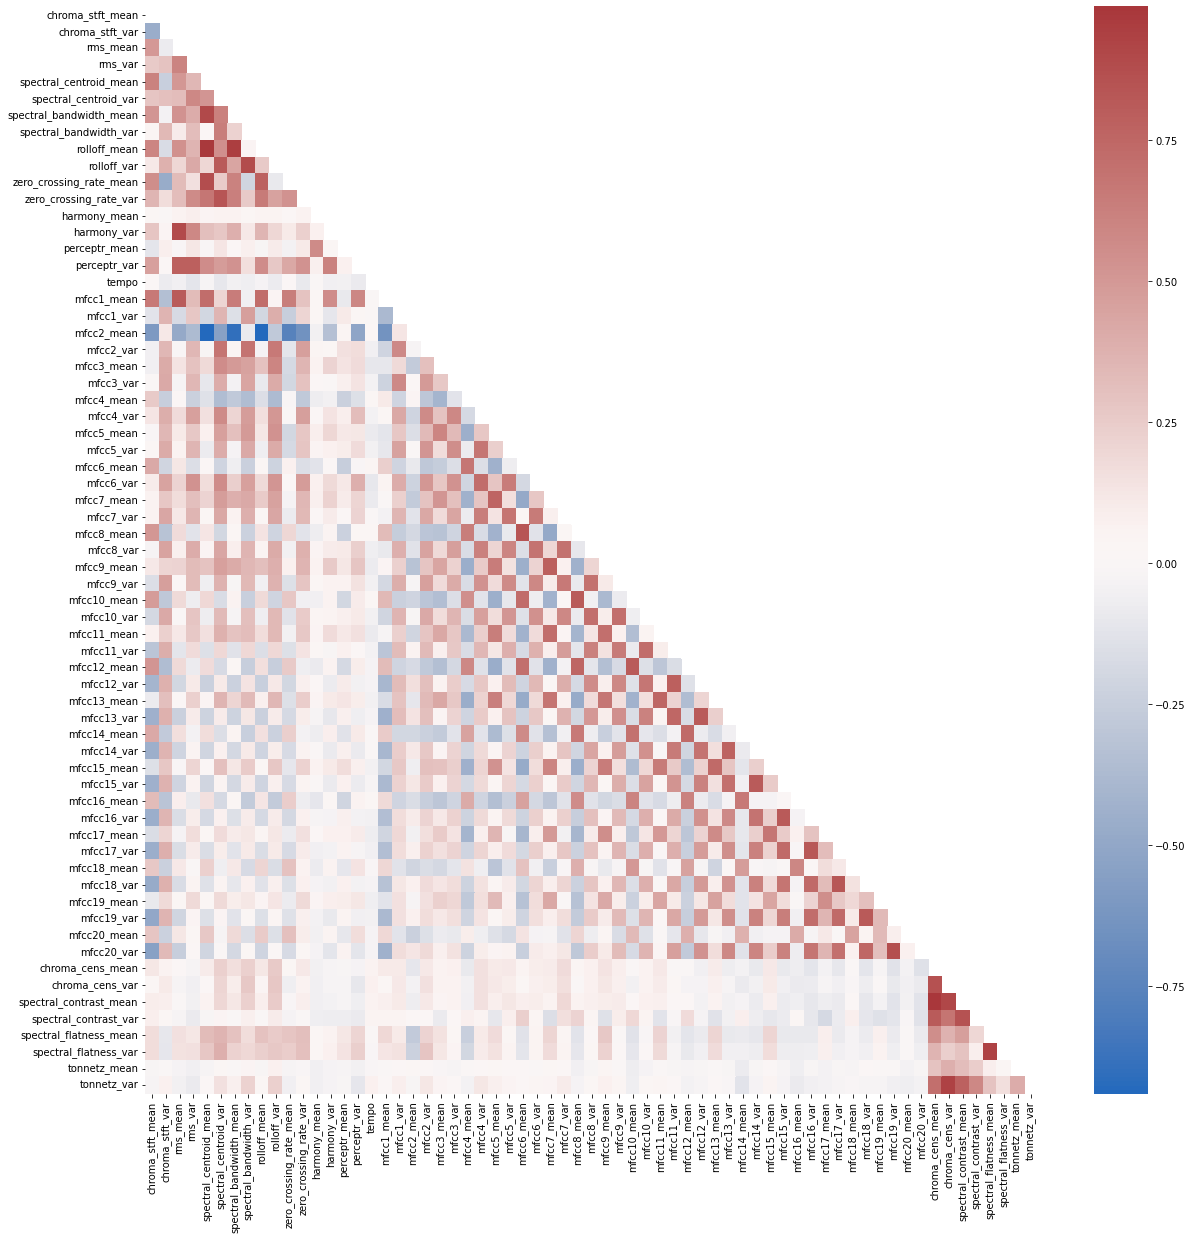

In [21]:
corr = df.corr()

#Create a mask for the heatmap
# heatmaps are used to study similarity and disparity
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap="vlag")

In [22]:
#Most of the variables do not have a high correlation with other variables. 
#Let's filter out the extremely highly correlated pairs and examine them.
#following is the code for filtering out the extremely highly correlated pairs and examining them
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
for index, value in sol.items():
    if (value > 0.75) or (value < -0.75):
        print(index, value)

('chroma_cens_mean', 'spectral_contrast_mean') 0.9874744425086118
('spectral_centroid_mean', 'rolloff_mean') 0.9796372839713288
('spectral_bandwidth_mean', 'rolloff_mean') 0.956189050738496
('chroma_cens_var', 'tonnetz_var') 0.9298365872247172
('spectral_flatness_mean', 'spectral_flatness_var') 0.9284320076948159
('chroma_cens_var', 'spectral_contrast_mean') 0.9050426908561425
('spectral_centroid_mean', 'spectral_bandwidth_mean') 0.9044346071495828
('rms_mean', 'harmony_var') 0.89389789497693
('spectral_bandwidth_var', 'rolloff_var') 0.8848769664091607
('spectral_centroid_mean', 'zero_crossing_rate_mean') 0.8747491925002671
('mfcc19_var', 'mfcc20_var') 0.8687180893195615
('chroma_cens_mean', 'chroma_cens_var') 0.860312370724887
('spectral_contrast_mean', 'spectral_contrast_var') 0.8553053076471314
('spectral_centroid_var', 'zero_crossing_rate_var') 0.8441413391352125
('mfcc6_mean', 'mfcc8_mean') 0.8373116484632829
('mfcc17_var', 'mfcc18_var') 0.8331488323994966
('mfcc16_var', 'mfcc17_v

In [23]:
#Given the small number of training data, I set 90% as training data and 10% as testing data. 
#For hyparameter tuning, given the small dataset, we will use the same train dataset to tune For the split of data, 
#I make sure every class has the same number of data to train and test.
y = df.label
X = df

#Use `label` to split data evenly and drop `label` column after split
#As label is expected to be output we splited it for testing the trained model 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=df.label, random_state=77)
X_train.drop('label',axis=1,inplace=True)
X_test.drop('label',axis=1,inplace=True)

In [24]:
#Normalizing the data
#Normalization is a technique often applied as part of data preparation for machine learning. 
#The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, 
#without distorting differences in the ranges of values or losing information.
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = sc.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# **Initial model fitting and recursive feature elimination**

In [25]:
#Now we will fit our training data to xgboost classifier first, 
#and then we'll do RFECV to check which variables can be eliminated.
estimator = XGBClassifier(eval_metric='merror')
rfecv = RFECV(estimator, step=1, cv=5,scoring='accuracy',verbose=1)
rfecv.fit(X_train, y_train)

Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 fe

RFECV(cv=5,
      estimator=XGBClassifier(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              eval_metric='merror', gamma=None, gpu_id=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None),

In [26]:
# See which features can be eliminated
features_drop_array = list(np.where(rfecv.support_ == False)[0])
X_train.columns[features_drop_array]

Index(['mfcc14_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_var', 'mfcc20_mean',
       'chroma_cens_var', 'spectral_contrast_mean', 'tonnetz_mean'],
      dtype='object')

In [27]:
#droping those features which are not required
X_train.drop(X_train.columns[features_drop_array], axis=1, inplace=True)
X_test.drop(X_test.columns[features_drop_array], axis=1, inplace=True)

# **MODEL TRAINING**

In [28]:
#We will just use XGBoost Classifier to classify
model = XGBClassifier(n_estimators=1000)
model.fit(X_train,y_train,eval_metric='merror')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=2,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [29]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
target_names = sorted(set(y))
#printing accuracy
print(f'Training accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Training:\n {classification_report(y_train, y_pred_train, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_pred_test)}')
print(f'Testing:\n {classification_report(y_test, y_pred_test, labels=target_names)}')

Training accuracy: 1.0
Training:
               precision    recall  f1-score   support

       blues       1.00      1.00      1.00        90
   classical       1.00      1.00      1.00        90
     country       1.00      1.00      1.00        90
       disco       1.00      1.00      1.00        90
      hiphop       1.00      1.00      1.00        90
        jazz       1.00      1.00      1.00        90
       metal       1.00      1.00      1.00        90
         pop       1.00      1.00      1.00        90
      reggae       1.00      1.00      1.00        90
        rock       1.00      1.00      1.00        90

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

Testing accuracy: 0.87
Testing:
               precision    recall  f1-score   support

       blues       0.90      0.90      0.90        10
   classical       0.90      0.90      0.90        10
     countr

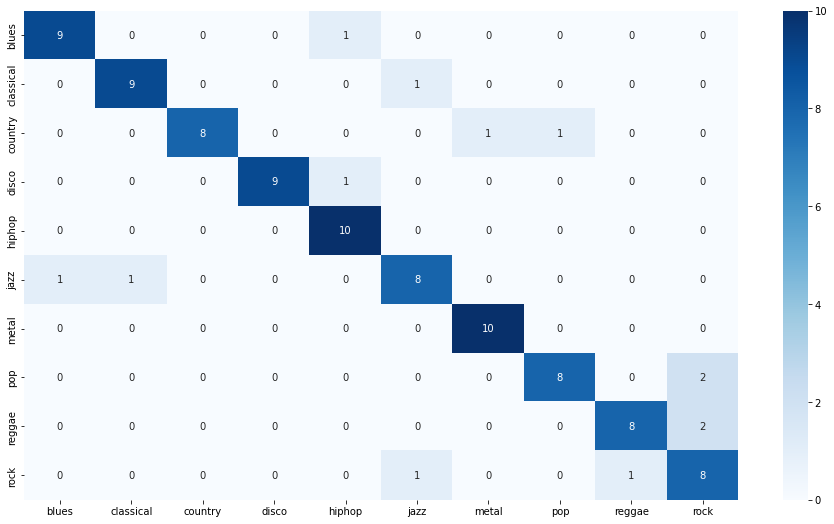

In [30]:
#Confusion matrix of the test data
#The matrix compares the actual target values with those predicted by the machine learning model.
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (16, 9))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

# **HYPER PARAMETER TUNING**

In [31]:
#Hyperparameter-tuning is important to find the possible best sets of hyperparameters to build the model from a specific dataset
#Hyperparameter tuning is choosing a set of optimal hyperparameters for a learning algorithm. 
#A hyperparameter is a model argument whose value is set before the learning process begins. 
space={
    'n_estimators': hp.quniform('n_estimators', 0,3000,1),
    'reg_lambda' : hp.quniform('reg_lambda', 0,500,1),
    }

def objective(space):
    clf=XGBClassifier(
                    n_estimators =int(space['n_estimators']),
                    reg_lambda = int(space['reg_lambda']),
                    )
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    


    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    return {'loss': -accuracy, 'status': STATUS_OK }


trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [18:41<00:00, 11.21s/it, best loss: -0.9]


In [32]:
#printing the best hyper parameters
print(f"best params: {best_hyperparams}")

best params: {'n_estimators': 2897.0, 'reg_lambda': 6.0}


In [33]:
#using best hyper parameters we fitted the XGBClassifier
model1 = XGBClassifier(n_estimators=304, reg_lambda=25)
model1.fit(X_train,y_train,eval_metric='merror')
y_pred_test1 = model1.predict(X_test)
#printing accuracy
print(f"accuracy: {accuracy_score(y_test,y_pred_test1)}")
print(f'New tuned model:\n {classification_report(y_test, y_pred_test1, labels=target_names)}')

accuracy: 0.85
New tuned model:
               precision    recall  f1-score   support

       blues       0.90      0.90      0.90        10
   classical       0.90      0.90      0.90        10
     country       1.00      0.70      0.82        10
       disco       1.00      0.70      0.82        10
      hiphop       0.71      1.00      0.83        10
        jazz       0.90      0.90      0.90        10
       metal       0.83      1.00      0.91        10
         pop       0.86      0.60      0.71        10
      reggae       0.82      0.90      0.86        10
        rock       0.75      0.90      0.82        10

    accuracy                           0.85       100
   macro avg       0.87      0.85      0.85       100
weighted avg       0.87      0.85      0.85       100



# **SAVE MODEL AND PREPROCESSING**

In [34]:
#saving the model and preprocessing using pickle dump
pickle.dump(sc, open('sc.pkl','wb'))
pickle.dump(model1, open('model.pkl', 'wb'))